In [1]:
from utils.fetch import fetch_train_for_dates
from utils.transform import train_list_to_dataframe
import datetime
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")

In [2]:
def plot_differences(
    df: pl.DataFrame, width: float = 10.0, height: float = 10.0
) -> None:
    fig, axs = plt.subplots(nrows=3, ncols=1)
    plt.tight_layout()

    fig.set_figwidth(val=width)
    fig.set_figheight(val=height)

    df = pl.concat([df.select(
        pl.col("train_number"),
        pl.col("departure_date"),
        pl.col("cancelled"),
        pl.col("train_type"),
        pl.lit("DEPARTURE").alias("type"),
        pl.col("departure_actual_difference").alias("delay"),
    ), df.select(
        pl.col("train_number"),
        pl.col("departure_date"),
        pl.col("cancelled"),
        pl.col("train_type"),
        pl.lit("ARRIVAL").alias("type"),
        pl.col("arrival_actual_difference").alias("delay"),
    )])

    sns.lineplot(
        data=df, x="departure_date", y="delay", hue="type", ax=axs[0]
    )
    axs[0].set_xlabel("Date")
    axs[0].set_ylabel("Schedule delay (min)")
    axs[0].set_ylim([0.0, 30.0])

    sns.histplot(data=df.filter(pl.col("type") == "DEPARTURE"), x="delay", binwidth=1.0, ax=axs[1])
    axs[1].set_title("Departure delays (min)")

    sns.histplot(data=df.filter(pl.col("type") == "ARRIVAL"), x="delay", binwidth=1.0, ax=axs[2])
    axs[2].set_title("Arrival delays (min)")

In [3]:
today = datetime.date.today()
date_list = [today - datetime.timedelta(days=diff) for diff in range(120)]
date_list = [d for d in date_list if d.weekday() < 5]

# Tampere -> Pasila

In [4]:
train_list_166 = await fetch_train_for_dates(
    train=166,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_166 = train_list_to_dataframe(
    train_list=train_list_166, departure="TPE", arrival="PSL"
)

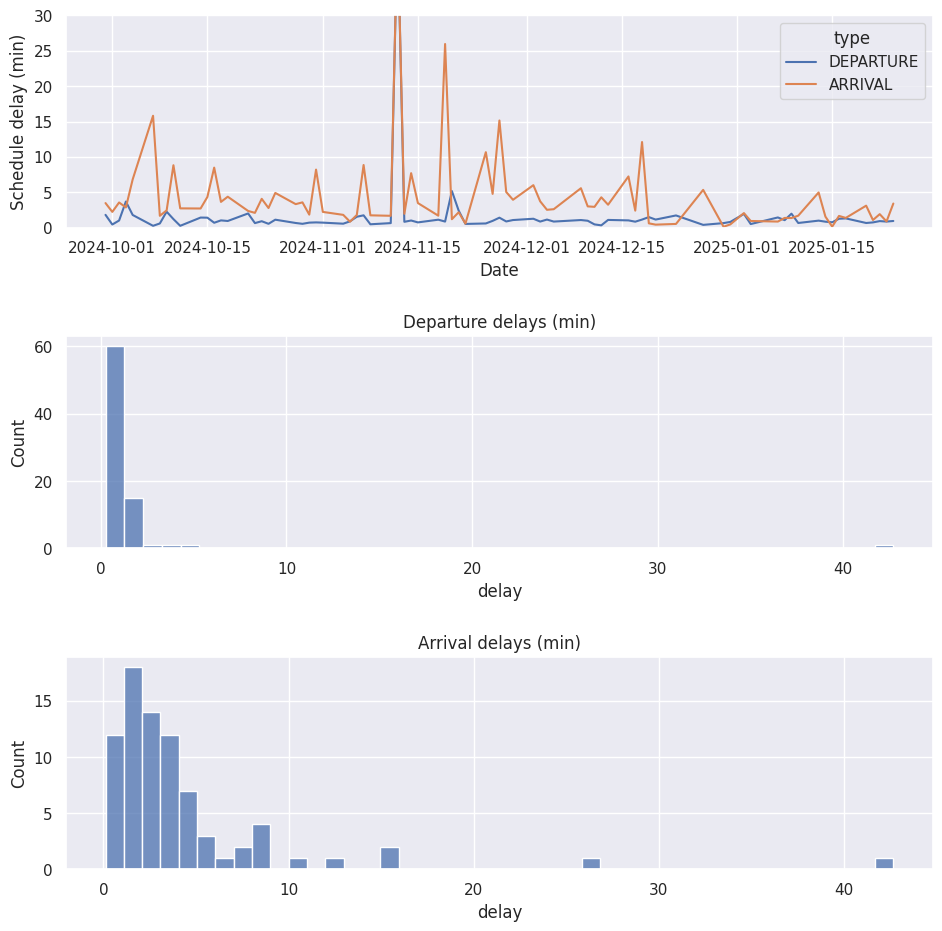

In [5]:
plot_differences(df=df_166)

In [6]:
train_list_40 = await fetch_train_for_dates(
    train=40,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_40 = train_list_to_dataframe(
    train_list=train_list_40, departure="TPE", arrival="PSL"
)

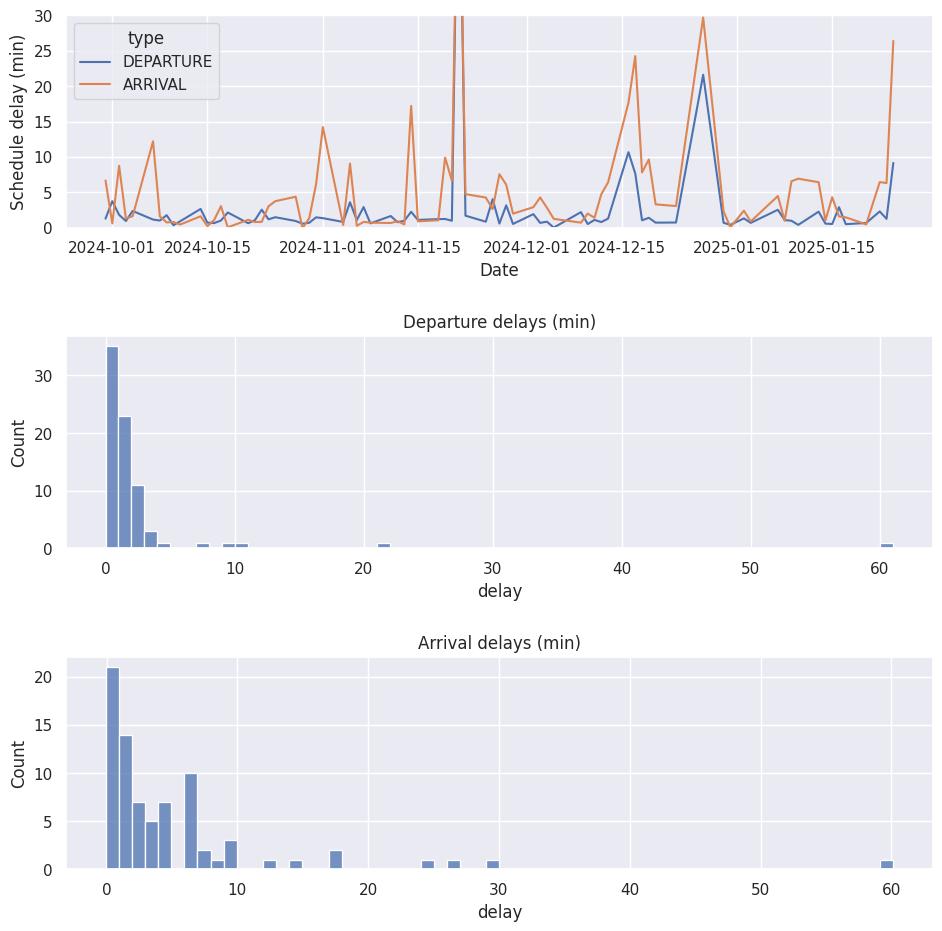

In [7]:
plot_differences(df=df_40)

In [8]:
train_list_80 = await fetch_train_for_dates(
    train=80,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_80 = train_list_to_dataframe(
    train_list=train_list_80, departure="TPE", arrival="PSL"
)

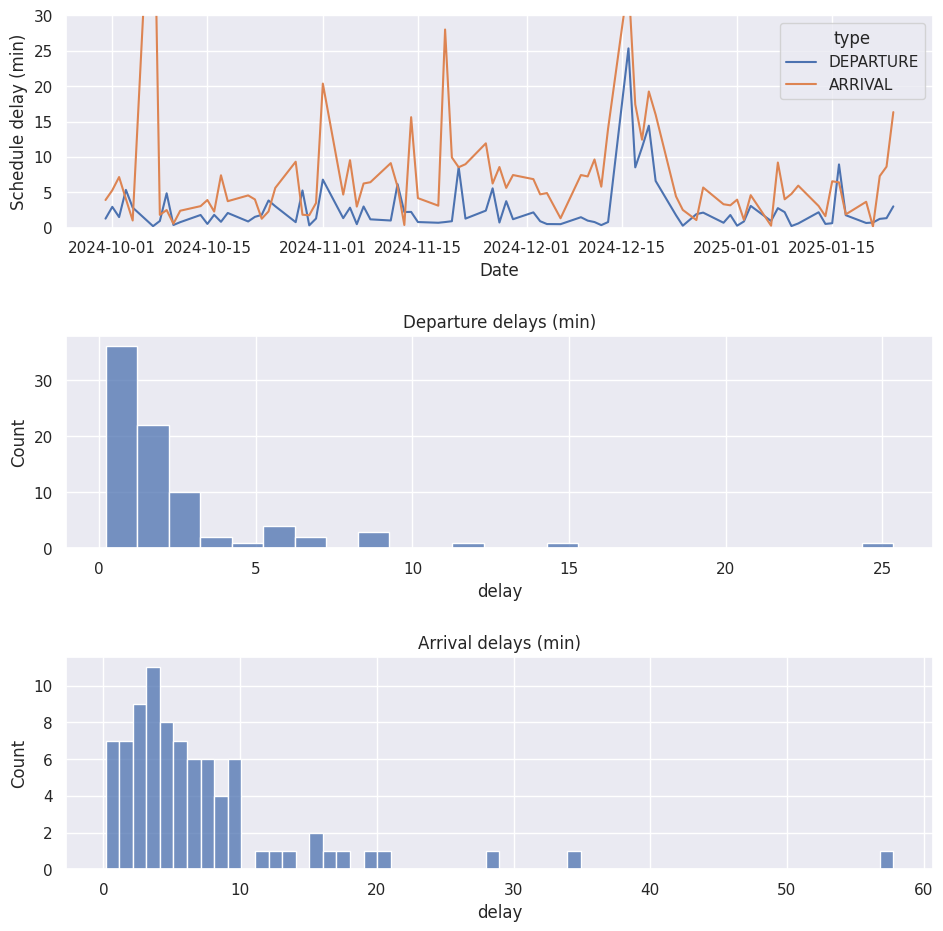

In [9]:
plot_differences(df=df_80)

# Pasila -> Tampere

In [10]:
train_list_51 = await fetch_train_for_dates(
    train=51,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_51 = train_list_to_dataframe(
    train_list=train_list_51, departure="TPE", arrival="PSL"
)

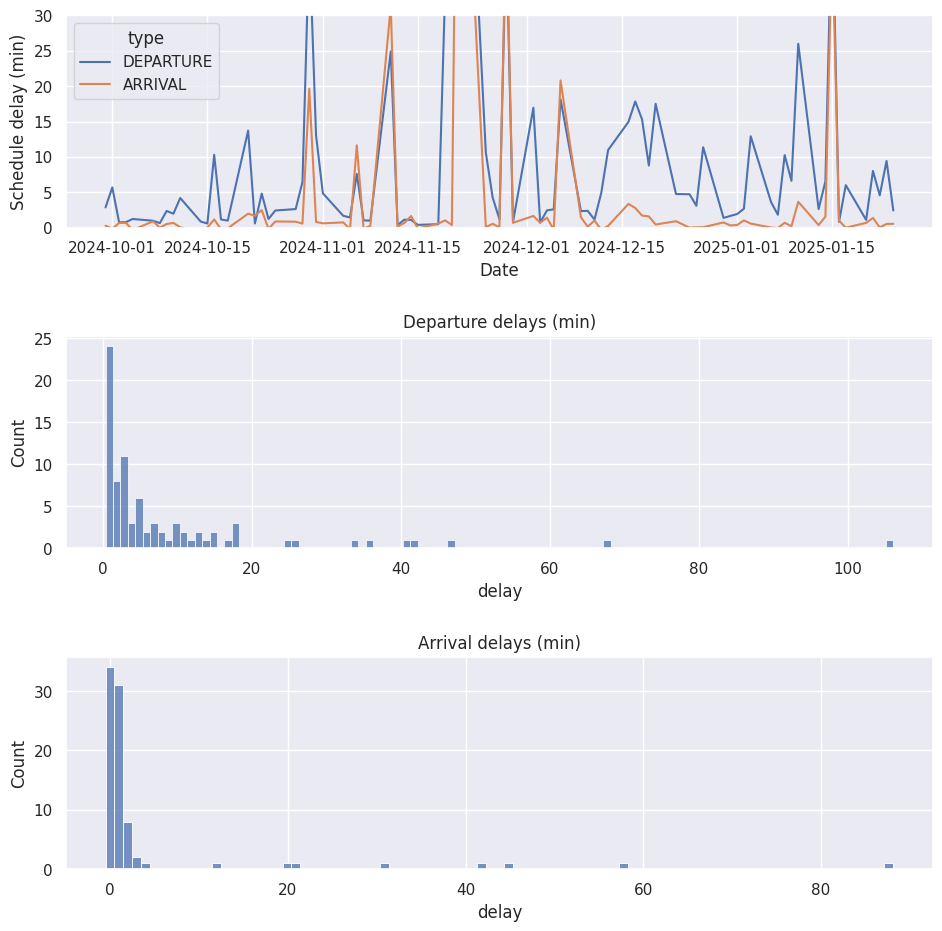

In [11]:
plot_differences(df=df_51)

In [12]:
train_list_59 = await fetch_train_for_dates(
    train=59,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_59 = train_list_to_dataframe(
    train_list=train_list_59, departure="PSL", arrival="TPE"
)

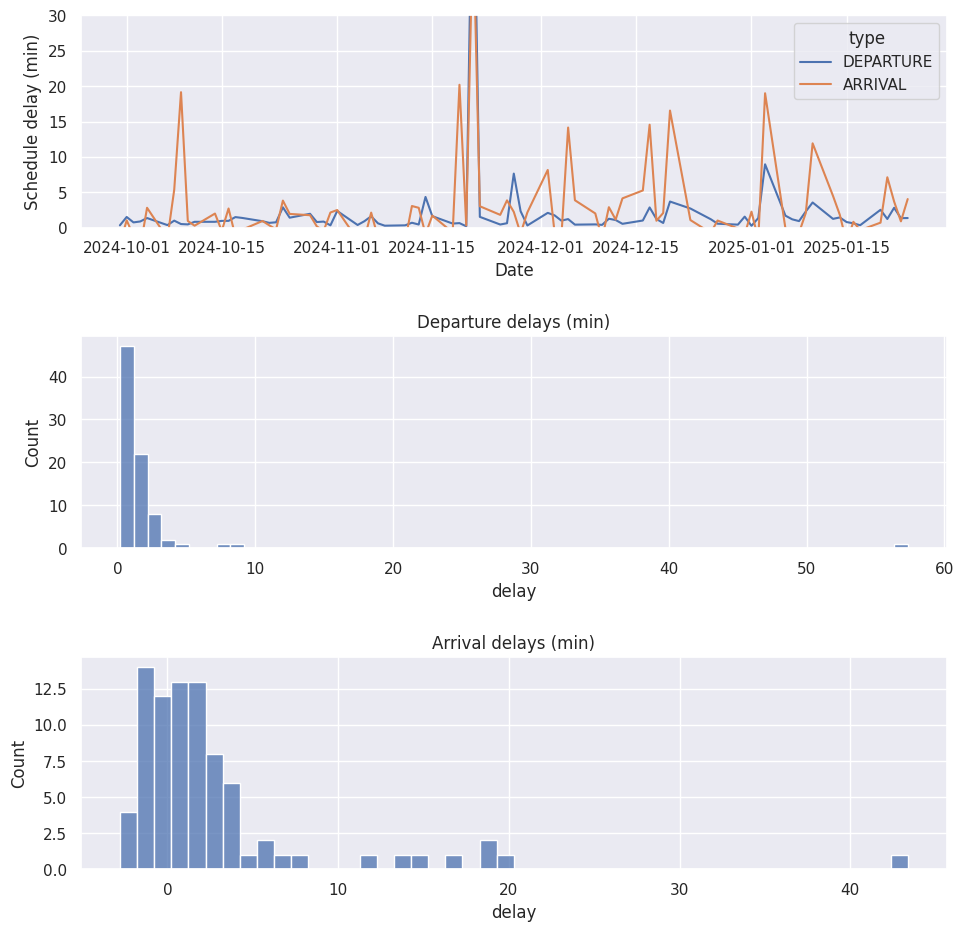

In [13]:
plot_differences(df=df_59)

In [14]:
train_list_177 = await fetch_train_for_dates(
    train=177,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_177 = train_list_to_dataframe(
    train_list=train_list_177, departure="PSL", arrival="TPE"
)

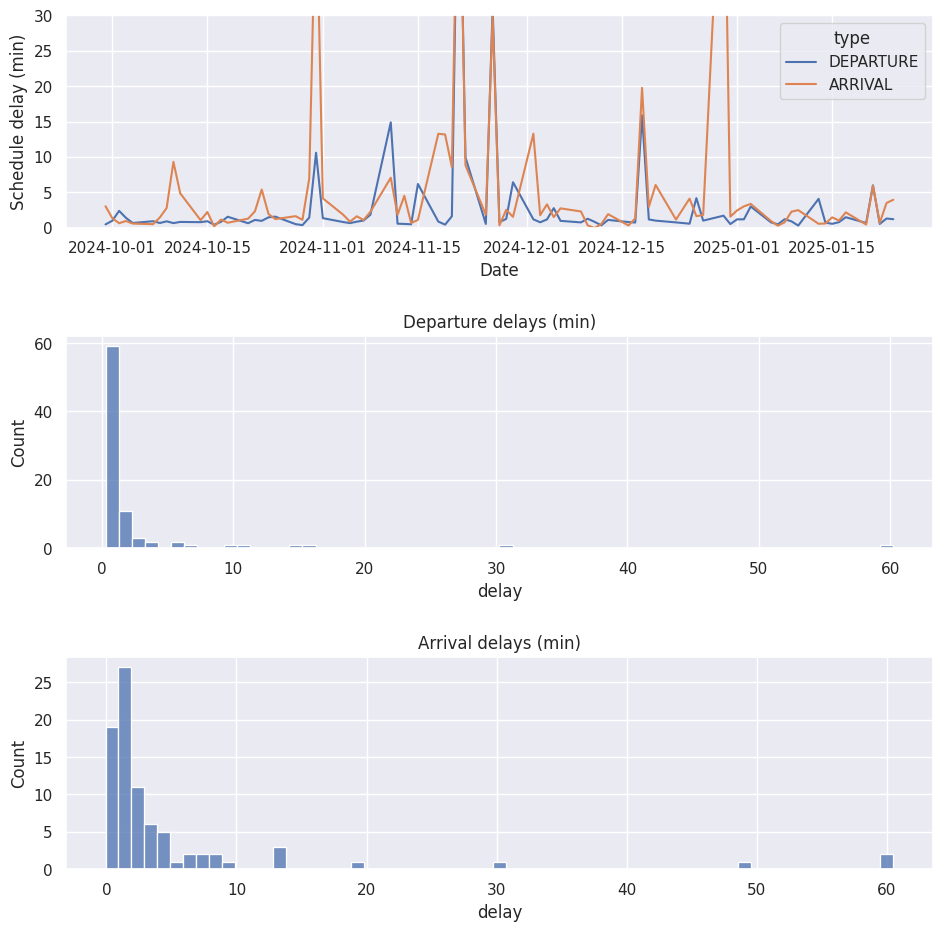

In [15]:
plot_differences(df=df_177)

In [16]:
train_list_49 = await fetch_train_for_dates(
    train=49,
    dates=date_list,
    max_concurrent=5,
    sleep_after_sec=1.0,
)
df_49 = train_list_to_dataframe(
    train_list=train_list_49, departure="PSL", arrival="TPE"
)

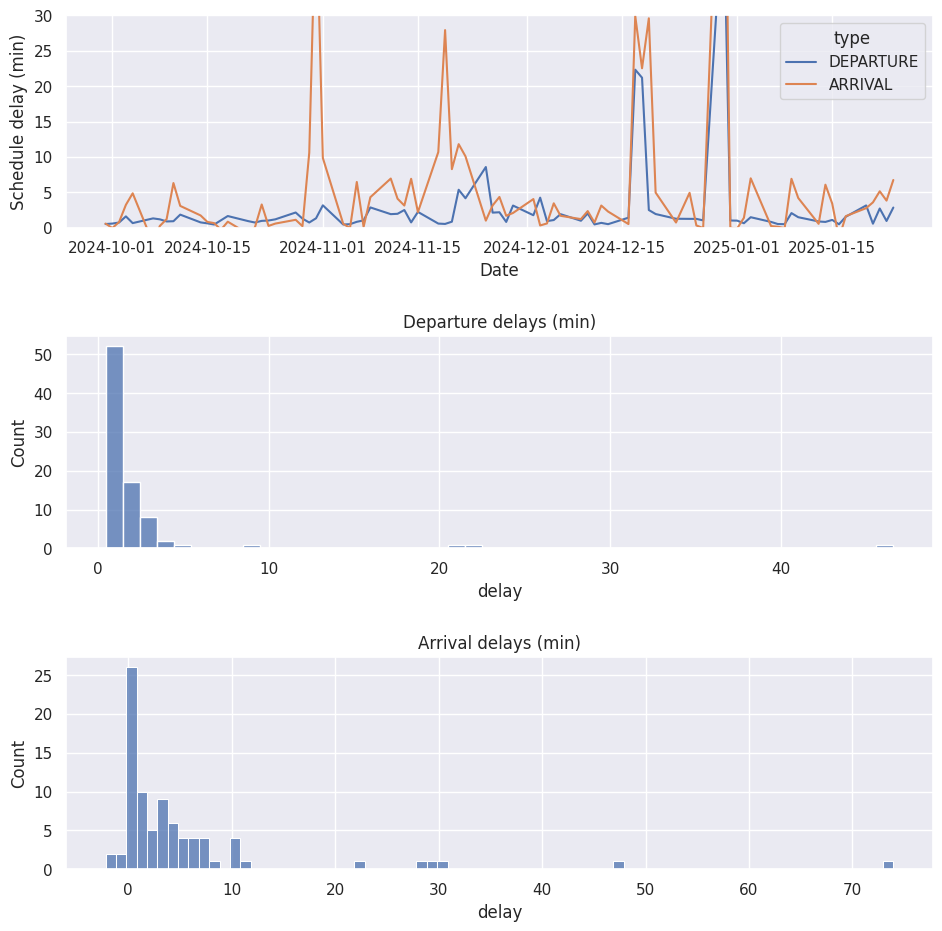

In [17]:
plot_differences(df=df_49)